In [1]:
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck

def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=100):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *(n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P


In [3]:


exp_file = hm.hiCMatrix('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5')
#chr_list_1 = exp_file.getChrNames()
    
exp_matrix = exp_file.matrix.toarray()
exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
df_exp = pd.DataFrame(exp_matrix ,  index=exp_genes_all , columns = exp_genes_all)

In [70]:

SRP_name='aggregates'

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/25kbp_raw/max/pcc/0/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'

pcc_sim = hm.hiCMatrix(exp_file_path)
all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
pcc_sim_matrix = pcc_sim.matrix.toarray() 

pcc_sim_matrix  = pcc_sim_matrix + 1
df_pcc_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)


In [67]:

df_jac_sim_list = []
#for resolution in ['10kbp_raw','25kbp_raw', '40kbp_raw', '100kbp_raw', '250kbp_raw']:
for resolution in ['10kbp_raw']:

    SRP_name='aggregates'

    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}/max/jac_sim/90/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'

    pcc_sim = hm.hiCMatrix(exp_file_path)
    all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
    pcc_sim_matrix = pcc_sim.matrix.toarray() 

    pcc_sim_matrix  = pcc_sim_matrix + 1
    df_jac_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)
    df_jac_sim_list.append(df_jac_sim)



In [3]:
contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_human/stats/'
df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

In [51]:
df_con

id  count
0    SRP105082    699
1    SRP012412    618
2    SRP118999    501
3    SRP050102    217
4    SRP117084    136
..         ...    ...
114  SRP132876      1
115  SRP132233      1
116  SRP111140      1
117  SRP105086      1
118  SRP071243      1

[119 rows x 2 columns]

In [16]:
#df_jac_sim_list_ind = []
for proj in df_con['id'].tolist()[15:119]:
    for resolution in ['10kbp_raw']:

        

        exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{proj}/{resolution}/max/jac_sim/90/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'

        pcc_sim = hm.hiCMatrix(exp_file_path)
        all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
        pcc_sim_matrix = pcc_sim.matrix.toarray() 

        pcc_sim_matrix  = pcc_sim_matrix + 1
        df_jac_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)
        df_jac_sim_list_ind.append(df_jac_sim)
    

OSError: ``/grid/gillis/data/lohia/hi_c_data_processing/data_human/SRP113633/10kbp_raw/max/jac_sim/90/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5`` does not exist

In [6]:
len(df_jac_sim_list_ind)

15

In [7]:
df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/stats/human_exclude_count_intra.txt', sep='\t')
df_con_counts = df_con.merge(df_seq_depth.groupby('proj_id')['counts_intra'].sum().reset_index(), left_on='id', right_on='proj_id')



In [49]:
df_jac_sim_list_non_ranked = []
#for resolution in ['10kbp_raw','25kbp_raw', '40kbp_raw', '100kbp_raw', '250kbp_raw']:
for resolution in ['10kbp_raw']:

    SRP_name='aggregates'

    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}/max/jac_sim/70/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'

    pcc_sim = hm.hiCMatrix(exp_file_path)
    all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
    pcc_sim_matrix = pcc_sim.matrix.toarray() 

    pcc_sim_matrix  = pcc_sim_matrix + 1
    df_jac_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)
    df_jac_sim_list_non_ranked.append(df_jac_sim)
    

OSError: ``/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/max/jac_sim/70/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5`` does not exist

In [5]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)

df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)



<ipython-input-5-314f7aa644d5>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [ ]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)

df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)

In [44]:
marker_gene_table

ENSG00000115041  ENSG00000092621  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000100031  ENSG00000136048  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000167617  ENSG00000114013  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000273079  ENSG00000168081  \
Immune system-Pro-B cells                   0                0   
Immune system-Pre-B cells                   0                0   
Immune system-Naive B cells                 0                0   
Immune system-Memory B cells                0                0   
Immune system-Plasma B cells                0                0   
...                                       ...              ...   
Teeth-Odontoblasts                          0                0   
Teeth-Endothelial cells                     0                0   
Teeth-Immune cells                          0                0   
Teeth-Glial cells                           0                0   
Teeth-Epithelial cells                      0                0   

                              ENSG00000196182  del  ...  ENSG00000105695  \
Immune system-Pro-B cells                   0    0  ...                0   
Immune system-Pre-B cells                   0    0  ...                0   
Immune system-Naive B cells                 0    0  ...                0   
Immune system-Memory B cells                0    0  ...                0   
Immune system-Plasma B cells                0    0  ...                0   
...                                       ...  ...  ...              ...   
Teeth-Odontoblasts                          0    0  ...                0   
Teeth-Endothelial cells                     0    0  ...                0   
Teeth-Immune cells                          0    0  ...                0   
Teeth-Glial cells                           0    0  ...                0   
Teeth-Epithelial cells

In [93]:
df_2d_jac = run_egad(marker_gene_table.T, df_jac_sim_list[0])

(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-82-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


<AxesSubplot:xlabel='P_Value', ylabel='Count'>

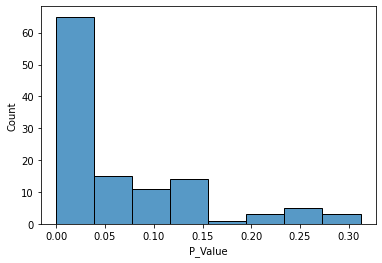

In [99]:
import seaborn as sns
sns.histplot(df_2d_jac['P_Value'])

In [ ]:
sns.histplot(df_2d_jac['P_Value'])

In [38]:
df_2d_jac['P_Value']

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC  \
Immune system-Pro-B cells     0.651692      2306.088453         0.446594   
Immune system-Pre-B cells     0.563162      2327.437020         0.503305   
Immune system-Naive B cells   0.642193      2272.248287         0.364908   
Immune system-Memory B cells  0.660029      2273.638583         0.365782   
Immune system-Plasma B cells  0.660029      2273.638583         0.365782   
...                                ...              ...              ...   
Teeth-Odontoblasts            0.343070      2333.020613         0.510422   
Teeth-Endothelial cells       0.552362      2282.003796         0.378949   
Teeth-Immune cells            0.512912      2260.432018         0.352664   
Teeth-Glial cells             0.447695      2327.346842         0.512429   
Teeth-Epithelial cells        0.687370      2265.016424         0.309789   

                               P_Value  
Immune system-Pro-B cells     0.006135  
Immune system-Pre-B cells     0.137641  
Immune system-Naive B cells   0.047086  
Immune system-Memory B cells  0.024545  
Immune system-Plasma B cells  0.024545  
...                                ...  
Teeth-Odontoblasts            0.057597  
Teeth-Endothelial cells       0.141349  
Teeth-Immune cells            0.337875  
Teeth-Glial cells             0.237159  
Teeth-Epithelial cells        0.036674  

[163 rows x 4 columns]

In [42]:
df_jac_sim_list[0]

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972         2.000000         1.440645         2.000000   
ENSG00000227232         1.440645         2.000000         1.440645   
ENSG00000278267         2.000000         1.440645         2.000000   
ENSG00000243485         1.117773         1.383108         1.117773   
ENSG00000284332         1.124672         1.222821         1.124672   
...                          ...              ...              ...   
ENSG00000100312         1.111997         1.201178         1.111997   
ENSG00000254499         1.115969         1.194400         1.115969   
ENSG00000213683         1.023170         1.022473         1.023170   
ENSG00000184319         1.105405         1.193105         1.105405   
ENSG00000079974         1.109440         1.198114         1.109440   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972         1.117773         1.124672         1.124672   
ENSG00000227232         1.383108         1.222821         1.222821   
ENSG00000278267         1.117773         1.124672         1.124672   
ENSG00000243485         2.000000         1.823542         1.823542   
ENSG00000284332         1.823542         2.000000         2.000000   
...                          ...              ...              ...   
ENSG00000100312         1.259998         1.250106         1.250106   
ENSG00000254499         1.228313         1.225698         1.225698   
ENSG00000213683         1.017021         1.018299         1.018299   
ENSG00000184319         1.268139         1.243699         1.243699   
ENSG00000079974         1.270070         1.247386         1.247386   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972         1.176170         1.152133         1.138835   
ENSG00000227232         1.222079         1.227561         1.219063   
ENSG00000278267         1.176170         1.152133         1.138835   
ENSG00000243485         1.218630         1.259493         1.264804   
ENSG00000284332         1.219592         1.250219         1.253223   
...                          ...              ...              ...   
ENSG00000100312         1.204406         1.236131         1.244543   
ENSG00000254499         1.192194         1.211524         1.215947   
ENSG00000213683         1.020268         1.017380         1.017164   
ENSG00000184319         1.212582         1.268340         1.278935   
ENSG00000079974         1.218986         1.271523         1.280611   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         1.102799  ...         1.144156         1.127891   
ENSG00000227232         1.187378  ...         1.187880         1.207548   
ENSG00000278267         1.102799  ...         1.144156         1.127891   
ENSG00000243485         1.268341  ...         1.199651         1.245055   
ENSG00000284332         1.240581  ...         1.198149         1.235914   
...                          ...  ...              ...              ...   
ENSG00000100312         1.240471  ...         1.238760         1.273890   
ENSG00000254499         1.196721  ...         1.222541         1.247275   
ENSG00000213683         1.012468  ...         1.017278         1.018553   
ENSG00000184319         1.325881  ...         1.276554         1.301324   
ENSG00000079974         1.315942  ...         1.290141         1.309204   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972         1.071700         1.103868         1.114375   
ENSG00000227232         1.157789         1.202662         1.163755   
ENSG00000278267         1.071700         1.103868         1.114375   
ENSG00000243485         1.273896         1.288029         1.167057   
ENSG00000284332         1.235536         1.267181         1.172266   
...                          ...              ...              ...   
ENSG00000100312         1.283542         1.291889         1.456527   
ENSG00000254499         1.195837 

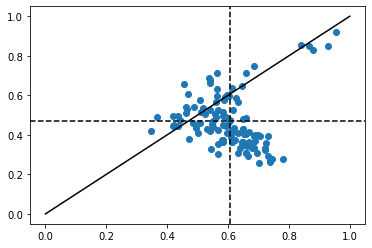

In [84]:

#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [71]:
df_2d_jac['AUC'].median()

0.6130787285407725

In [72]:
df_jac_sim_list_99 = []
for resolution in ['10kbp_raw','25kbp_raw', '40kbp_raw', '100kbp_raw', '250kbp_raw']:

    SRP_name='aggregates'

    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}/max/jac_sim/99/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'

    pcc_sim = hm.hiCMatrix(exp_file_path)
    all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
    pcc_sim_matrix = pcc_sim.matrix.toarray() 

    pcc_sim_matrix  = pcc_sim_matrix + 1
    df_jac_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)
    df_jac_sim_list_99.append(df_jac_sim)
    

OSError: ``/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/max/jac_sim/99/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5`` does not exist

In [ ]:
df_jac_sim_list_50 = []
for resolution in ['10kbp_raw','25kbp_raw', '40kbp_raw', '100kbp_raw', '250kbp_raw']:

    SRP_name='aggregates'

    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}/max/jac_sim/50/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'

    pcc_sim = hm.hiCMatrix(exp_file_path)
    all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
    pcc_sim_matrix = pcc_sim.matrix.toarray() 

    pcc_sim_matrix  = pcc_sim_matrix + 1
    df_jac_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)
    df_jac_sim_list_50.append(df_jac_sim)
    
    

In [ ]:
df_contact_list = []
for resolution in ['100kbp_raw', '10kbp_raw', '40kbp_raw']:

    SRP_name='aggregates'

    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}/hic_gene_gw_KR_KR.h5'

    pcc_sim = hm.hiCMatrix(exp_file_path)
    all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
    pcc_sim_matrix = pcc_sim.matrix.toarray() 

    pcc_sim_matrix  = pcc_sim_matrix + 1
    df_jac_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)
    df_contact_list.append(df_jac_sim)

In [27]:
 pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
    
    

<ipython-input-27-a2637dce51b5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


Tissue          Cell type  \
0    Immune system        Pro-B cells   
1    Immune system        Pre-B cells   
2    Immune system      Naive B cells   
3    Immune system     Memory B cells   
4    Immune system     Plasma B cells   
..             ...                ...   
227          Teeth       Odontoblasts   
228          Teeth  Endothelial cells   
229          Teeth       Immune cells   
230          Teeth        Glial cells   
231          Teeth   Epithelial cells   

                                          Marker genes Negative markers  
0    CD27,IgD,CD24,PTPRC,PAX5,CD24,CD38,CD79A,DNTT,...              NaN  
1    CD19,CD27,IgD,CD24,PTPRC,PAX5,CD24,CD38,CD79A,...              NaN  
2    CD19,IgD,CD38,CD24,CD20,MS4A1,PTPRC,PAX5,CD24,...              NaN  
3    CD19,CD27,IgD,CD38,CD24,CD20,MS4A1,PTPRC,PAX5,...              NaN  
4    CD19,CD27,IgD,CD38,CD24,CD20,MS4A1,PTPRC,PAX5,...       CD20,MS4A1  
..                                                 ...              ...  
227  DSPP,DMP1,SMOC2,COL1A1,FGF3,S100A13,SALL1,PTN,...              NaN  
228  EDN1,CLDN5,ACKR1,CD234,INSR,RGCC,CTNNB1,CLDN5,...              NaN  
229  CD69,ITGB2,CD2,CD3G,CD3E,CD8A,CD14,HLA-DRA,B2M...              NaN  
230  SOX10,MBP,GFRA3,SOX2,PLP1,SOX10,SCN7A,KCNA2,GF...              NaN  
231  KRT14,ODAM,WNT10A,IL1A,IL1B,KRT5,SFN,FDCSP,SLP...              NaN  

[232 rows x 4 columns]

In [9]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)

df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)

<ipython-input-9-314f7aa644d5>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [18]:
marker_gene_table.sum(axis=1).reset_index()

index   0
0       Immune system-Pro-B cells  20
1       Immune system-Pre-B cells  18
2     Immune system-Naive B cells  22
3    Immune system-Memory B cells  23
4    Immune system-Plasma B cells  23
..                            ...  ..
224            Teeth-Odontoblasts  12
225       Teeth-Endothelial cells   9
226            Teeth-Immune cells  12
227             Teeth-Glial cells   9
228        Teeth-Epithelial cells  11

[229 rows x 2 columns]

In [34]:
df_AUC_degree = df_2d_jac.merge(marker_gene_table.sum(axis=1).reset_index(), left_on=df_2d_jac.index, right_on= 'index' )


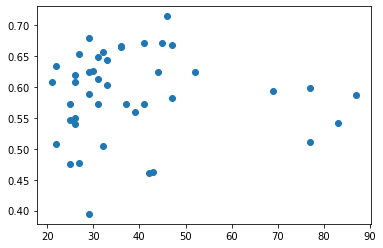

In [35]:
plt.scatter(df_AUC_degree[0], df_AUC_degree['AUC'])

In [ ]:
df_2d_jac.merge(marker_gene_table.sum(axis=1).reset_index(), left_on=df_2d_jac.index, right_on= 'index' )

<AxesSubplot:ylabel='Count'>

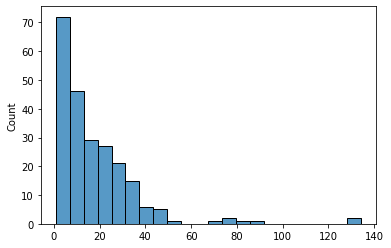

In [230]:
sns.histplot(marker_gene_table.sum(axis=1))

In [93]:
len(tissue_type_list)

16

In [29]:
marker_gene_table.drop('del', axis=1, inplace=True)

In [145]:
df_2d_jac_exp = run_egad(marker_gene_table.T, df_exp)

(1690, 1690)
(1690, 229)
0.9919459445492365
0.0


<ipython-input-22-0a2b6b600218>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [205]:
df_2d_jac = run_egad(marker_gene_table.T, df_pcc_sim)

(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-22-0a2b6b600218>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [208]:
df_2d_jac = run_egad(marker_gene_table.T, df_jac_sim_list[0])

(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-22-0a2b6b600218>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [17]:
auc_jac_list = []
for i in df_jac_sim_list_ind:
    df_2d_jac = run_egad(marker_gene_table.T, i )
    print (auc_jac_list.append(df_2d_jac['AUC'].mean()))
    print (df_2d_jac['AUC'].mean())

(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5478666523963367
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.6077983448541736
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.6037518790874411
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.610490974864261
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5482341491441043
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.603544713759272
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5493494733616472
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5487171740026664
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5508072299105309
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5465754501142221
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5455937807299465
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5460952187666505
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5435415447084472
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5478870477715007
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5405485928331462
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5455567632789043
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.544795459726694
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5451501263248906
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5444928312581832
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5570267525076241
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5430725186614915
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.6037730746455443
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5467713335051751
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5452080193116711
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5470649484988882
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5476524829029704
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5446049828341154
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5427023281090035
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5542697655489663
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5461841907950281
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5452009479480655
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5455429140264625
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5519469048281284
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5433162793552511
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5421693335204197
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5471478702690418
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5455145446418084
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5457731956602255
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5460658364780024
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.543643693473795
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5448061138736785
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5429325451344846
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5473702852125099
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5481116754745567
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5523583785497245
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5462614220353287
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5557237201710151
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5456651872684086
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.552146265576287
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5504078888034903
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5445623125005478
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5412072797014926
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.552185694900836
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5430839496693747
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5516737531242312
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5514143179237865
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5522253774094744
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5510717420040057
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5443213766055424
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5470551121197479
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5512578351716366
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5441456283088217
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5518240950440061
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


None
0.5443677602285047
(1939, 1939)
(1939, 229)
0.9921356842202459
0.0
None
0.5529608656823725


<ipython-input-2-5da84e1c92f3>:134: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


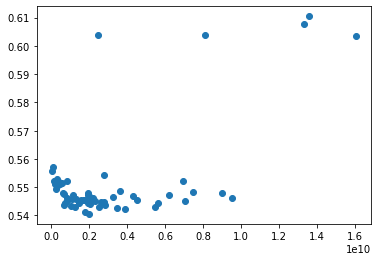

In [22]:
import numpy as np
df_con_counts['counts_inter_log'] = [np.log10(x) for x in df_con_counts['counts_intra']]
plt.scatter(x=df_con_counts['counts_intra'][0:65], y=auc_jac_list)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

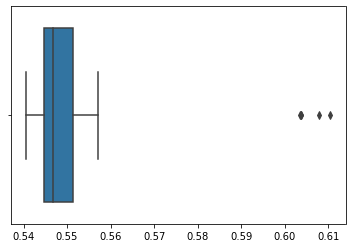

In [30]:
import seaborn as sns
sns.boxplot(auc_jac_list, orient='h')

In [24]:
auc_jac_list.sort()

In [25]:
auc_jac_list

[0.5405485928331462,
 0.5412072797014926,
 0.5421693335204197,
 0.5427023281090035,
 0.5429325451344846,
 0.5430725186614915,
 0.5430839496693747,
 0.5433162793552511,
 0.5435415447084472,
 0.543643693473795,
 0.5441456283088217,
 0.5443213766055424,
 0.5443677602285047,
 0.5444928312581832,
 0.5445623125005478,
 0.5446049828341154,
 0.544795459726694,
 0.5448061138736785,
 0.5451501263248906,
 0.5452009479480655,
 0.5452080193116711,
 0.5455145446418084,
 0.5455429140264625,
 0.5455567632789043,
 0.5455937807299465,
 0.5456651872684086,
 0.5457731956602255,
 0.5460658364780024,
 0.5460952187666505,
 0.5461841907950281,
 0.5462614220353287,
 0.5465754501142221,
 0.5467713335051751,
 0.5470551121197479,
 0.5470649484988882,
 0.5471478702690418,
 0.5473702852125099,
 0.5476524829029704,
 0.5478666523963367,
 0.5478870477715007,
 0.5481116754745567,
 0.5482341491441043,
 0.5487171740026664,
 0.5493494733616472,
 0.5504078888034903,
 0.5508072299105309,
 0.5510717420040057,
 0.551257835171

In [20]:
len(auc_jac_list)

65

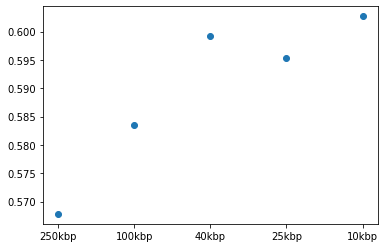

In [212]:
plt.scatter(['250kbp','100kbp','40kbp','25kbp','10kbp'],auc_jac_list)

In [77]:
y = auc_jac_list.append(df_2d_jac['AUC'].median())

In [31]:
df_2d_jac['AUC'].mean()

0.5529608656823725

In [92]:
auc_jac_list

[0.5460465652374366,
 0.617938733125649,
 0.6148761838417011,
 0.6075938418958657,
 0.5439975010683166,
 0.6077128276501972,
 0.5338868707836014]

In [79]:
len(y)

TypeError: object of type 'NoneType' has no len()

ValueError: x and y must be the same size

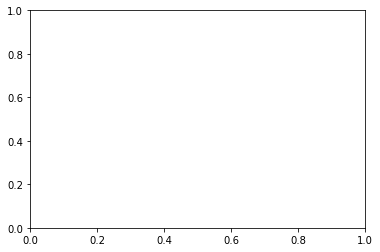

In [78]:
plt.scatter(x=[0,1,2,3,4,5,6,7], y=y)

In [65]:
auc_jac_list

[0.5387271046397412,
 0.6118513592912757,
 0.6122607346094154,
 0.6225041717014789,
 0.5303173567366725,
 0.6159795243204579,
 0.5224358974358975]

In [64]:
df_2d_jac['AUC'].median()

0.6130787285407725

In [1]:
auc_jac_list

NameError: name 'auc_jac_list' is not defined

In [41]:
df_2d_jac[df_2d_jac['AUC'] > 0.7]

AUC  AVG_NODE_DEGREE  \
Immune system-Eosinophils                         0.757848      2240.825928   
Immune system-Non-classical monocytes             0.750192      2245.215639   
Immune system-Intermediate monocytes              0.779694      2258.887481   
Immune system-ISG expressing immune cells         0.717064      2209.948076   
Liver-Immune system cells                         0.713625      2304.021922   
Eye-Muller cells                                  0.764227      2265.813037   
Eye-Rod bipolar cells                             0.778109      2358.793020   
Eye-GABAergic amacrine cells                      0.759783      2365.928230   
Eye-Extracellular matrix cells                    0.713311      2373.437170   
Eye-Glycinergic amacrine cells                    0.711992      2375.081768   
Eye-Starburst amacrine cells                      0.705349      2362.347042   
Kidney-Podocytes                                  0.700807      2388.481268   
Kidney-Stromal cells                              0.708132      2337.080779   
Kidney-Ureteric Bud cells                         0.720706      2342.081029   
Brain-Neuroepithelial cells                       0.713982      2313.235505   
Brain-Oligodendrocyte precursor cells             0.756079      2367.226548   
Skin-Keratinocytes                                0.705439      2262.290399   
Skin-Langerhans cells                             0.709647      2280.702664   
White adipose tissue-Adipocytes                   0.743923      2406.008097   
White adipose tissue-Adipose progenitor cells     0.773199      2396.807093   
White adipose tissue-Smooth Muscle cells          0.856767      2437.261643   
White adipose tissue-Pericytes                    0.896866      2436.613786   
White adipose tissue-Endothelial cells            0.856280      2433.706882   
White adipose tissue-Lymphatic Endothelial cells  0.879046      2428.529790   
White adipose tissue-Mesothelial cells            0.858105      2409.176326   
White adipose tissue-Endometrium                  0.951841      2457.009410   

                                                  DEGREE_NULL_AUC  \
Immune system-Eosinophils                                0.270555   
Immune system-Non-classical monocytes                    0.276944   
Immune system-Intermediate monocytes                     0.276452   
Immune system-ISG expressing immune cells                0.268955   
Liver-Immune system cells                                0.415073   
Eye-Muller cells                                         0.293695   
Eye-Rod bipolar cells                                    0.613271   
Eye-GABAergic amacrine cells                             0.687241   
Eye-Extracellular matrix cells                           0.659305   
Eye-Glycinergic amacrine cells                           0.711339   
Eye-Starburst amacrine cells                             0.660705   
Kidney-Podocytes                                         0.714558   
Kidney-Stromal cells                                     0.537415   
Kidney-Ureteric Bud cells                                0.566520   
Brain-Neuroepithelial cells                              0.466274   
Brain-Oligodendrocyte precursor cells                    0.696068   
Skin-Keratinocytes                                       0.335011   
Skin-Langerhans cells                                    0.457960   
White adipose tissue-Adipocytes                          0.749953   
White adipose tissue-Adipose progenitor cells            0.727683   
White adipose tissue-Smooth Muscle cells                 0.856099   
White adipose tissue-Pericytes                           0.851064   
White adipose tissue-Endothelial cells                   0.847401   
White adipose tissue-Lymphatic Endothelial cells         0.831309   
White adipose tissue-Mesothelial cells                   0.764953   
White adipose tissue-Endometrium                         0.920688   

                                                       P_

In [213]:
df_2d_jac_exp[df_2d_jac_exp['AUC'] < 0.2]

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC  \
Kidney-Juxtaglomerular cells  0.147808       472.507101         0.249111   

                               P_Value  
Kidney-Juxtaglomerular cells  0.079575

In [153]:
df_merged = df_2d_jac_exp.merge(df_2d_jac, left_on=df_2d_jac_exp.index, right_on=df_2d_jac.index)

In [109]:
df_merged

key_0     AUC_x  AVG_NODE_DEGREE_x  \
0                    Pro-B cells  0.901526         583.079133   
1                    Pre-B cells  0.916579         649.739336   
2                  Naive B cells  0.943434         644.537238   
3                 Memory B cells  0.950030         648.858411   
4                 Plasma B cells  0.950030         648.858411   
..                           ...       ...                ...   
171  Lymphatic Endothelial cells  0.843477         727.676952   
172                  Endometrium  0.816786         688.510269   
173       Mesenchymal stem cells  0.907287         693.600934   
174                 Odontoblasts  0.838905         680.723288   
175                  Glial cells  0.842620         615.871288   

     DEGREE_NULL_AUC_x     P_Value_x     AUC_y  AVG_NODE_DEGREE_y  \
0             0.372486  2.227080e-07  0.585797        2306.088453   
1             0.450582  1.423311e-09  0.494195        2327.437020   
2             0.446903  8.294984e-11  0.604897        2272.248287   
3             0.450282  1.184077e-11  0.623716        2273.638583   
4             0.450282  1.184077e-11  0.623716        2273.638583   
..                 ...           ...       ...                ...   
171           0.541788  2.757293e-05  0.878875        2428.529790   
172           0.496871  8.910896e-05  0.957150        2457.009410   
173           0.474777  1.170870e-03  0.670633        2334.449570   
174           0.469363  1.111782e-03  0.259958        2333.020613   
175           0.390971  2.880867e-04  0.153058        2327.346842   

     DEGREE_NULL_AUC_y     P_Value_y  
0             0.446594  5.980032e-02  
1             0.503305  1.502283e-01  
2             0.364908  2.306105e-02  
3             0.365782  9.301232e-03  
4             0.365782  9.301232e-03  
..                 ...           ...  
171           0.831309  3.335638e-08  
172           0.920688  2.911096e-08  
173           0.516123  1.188097e-01  
174           0.510422  2.121091e-03  
175           0.512429  3.798164e-04  

[176 rows x 9 columns]

In [110]:
import seaborn as sns

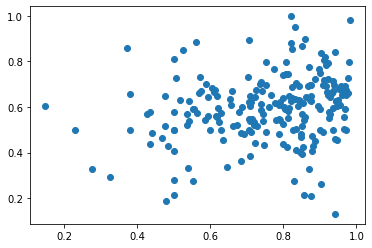

In [216]:
plt.scatter(df_merged['AUC_x'], df_merged['AUC_y'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_x', ylabel='AUC_y'>

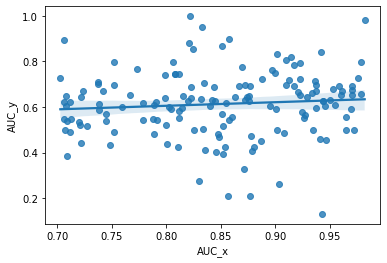

In [160]:
sns.regplot((df_merged[df_merged['AUC_x'] > 0.7]['AUC_x']), (df_merged[df_merged['AUC_x'] > 0.7]['AUC_y']))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_x', ylabel='AUC_y'>

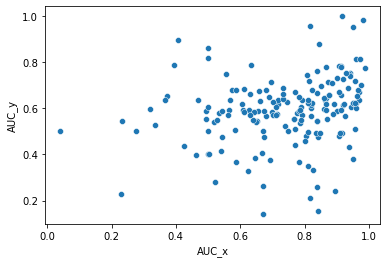

In [136]:
sns.scatterplot((df_merged[df_merged['AUC_x'] > -0.5]['AUC_x']), (df_merged[df_merged['AUC_x'] > -0.5]['AUC_y']))

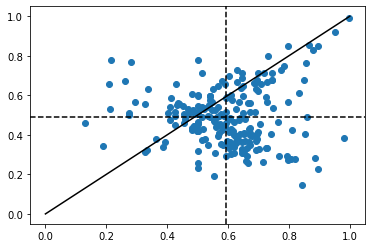

In [209]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

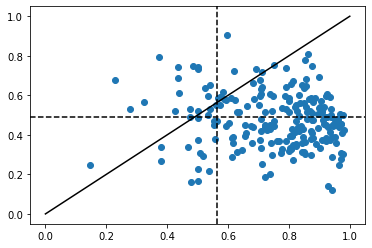

In [203]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_jac_exp['AUC'], df_2d_jac_exp['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [210]:
df_2d_jac['AUC'].median()

0.6027143740379034

In [166]:
df_2d_jac['AUC'].median()

0.5952998099187835

In [168]:
df_2d_jac['AUC'].median()

0.5992619926199262

In [81]:
df_2d_jac['AUC'].median()

0.5676599062451572

In [204]:
df_2d_jac_exp['AUC'].median()

0.8013160628121961

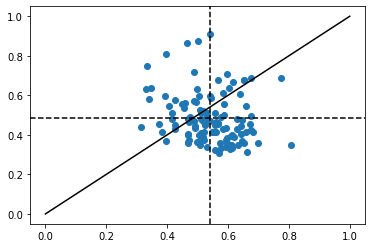

In [12]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [36]:
df_pcc_sim.max()

ENSG00000223972    1.0
ENSG00000227232    1.0
ENSG00000278267    1.0
ENSG00000243485    1.0
ENSG00000284332    1.0
                  ... 
ENSG00000100312    1.0
ENSG00000254499    1.0
ENSG00000213683    1.0
ENSG00000184319    1.0
ENSG00000079974    1.0
Length: 55411, dtype: float64

In [37]:
df_pcc_sim.min()

ENSG00000223972   -0.003428
ENSG00000227232   -0.003428
ENSG00000278267   -0.003428
ENSG00000243485   -0.003428
ENSG00000284332   -0.003428
                     ...   
ENSG00000100312   -0.002946
ENSG00000254499   -0.002946
ENSG00000213683   -0.002946
ENSG00000184319   -0.004990
ENSG00000079974   -0.004942
Length: 55411, dtype: float64

In [198]:
sns.histplot(df_jac_sim_list[0].values[0:100] - 1)

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ffb923ba4c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ffb923234c0> (for post_execute):


KeyboardInterrupt: 

In [202]:
np.median(df_jac_sim_list[0].values)

1.122240022288779

In [ ]:
sns.histplot(df_jac_sim_list[0].values - 1)

In [196]:
df_jac_sim_list[0].values[0] - 1

array([1.        , 0.44064494, 1.        , ..., 0.02317023, 0.10540469,
       0.10943987])